[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1YT9-4CNz8RjtTBeop6-9O3q13MaHU50O?usp=sharing)

Submission by: Chiara Vega

# Introduction

The code in this notebook performs prediction on the Kaggle House Prices dataset using regression techniques.

I will be utilizing LightGBM and XGBoost models to run my prediction tasks and SHAP to analyze and interpret the dataset features.

Link to the Kaggle dataset can be found here:

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

# Installation

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 31.8 MB/s eta 0:00:00


In [ ]:
!pip install Kaggle

# Download Kaggle Dataset

In [ ]:
# Kaggle API credentials
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kcpv24","key":"b93c3b11b4bb66b4cdec969cc0408490"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
# List of available Kaggle competitions
!kaggle competitions list

ref                                                                                           deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/asl-fingerspelling                                        2023-08-24 23:59:00  Research          $200,000        492           False  
https://www.kaggle.com/competitions/2023-kaggle-ai-report                                     2023-07-05 23:59:00  Analytics          $70,000        183           False  
https://www.kaggle.com/competitions/icr-identify-age-related-conditions                       2023-08-10 23:59:00  Featured           $60,000       4264           False  
https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature                      2023-07-31 23:59:00  Research           $50,000    

In [ ]:
# Download the House Prices competition dataset
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 94.6MB/s]


In [ ]:
# Unzip the downloaded dataset
!unzip /content/house-prices-advanced-regression-techniques.zip

Archive:  /content/house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Import Libraries and Load Dataset

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor

import shap

In [ ]:
# Load train.csv and test.csv and print shapes
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# EDA

In [ ]:
# Print shape of training and test data
print(f"Training data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")

Training data shape: (1460, 81)
Test data shape: (1459, 80)


In [ ]:
# Display training data information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Target variable: SalePrice

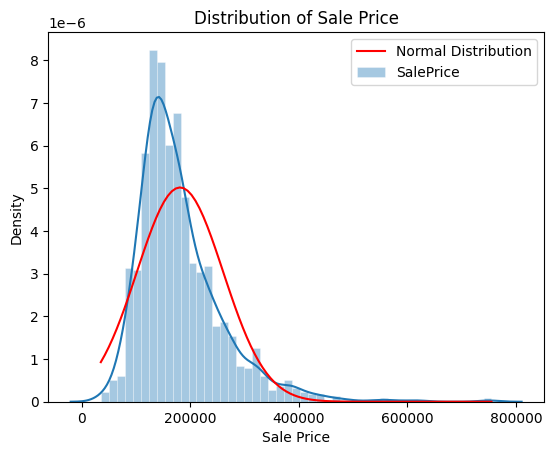

In [ ]:
# Plot distribution of SalePrice
sns.histplot(df_train['SalePrice'], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4), label='SalePrice')

mu, sigma = df_train['SalePrice'].mean(), df_train['SalePrice'].std()
x = np.linspace(df_train['SalePrice'].min(), df_train['SalePrice'].max(), 100)
y = norm.pdf(x, mu, sigma)

plt.plot(x, y, 'r-', label='Normal Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Density')
plt.title('Distribution of Sale Price')
plt.legend()
plt.show()

The distribution of SalePrice appears to be positive/right skewed.

In [ ]:
# Display descriptive statistics
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,12.024051
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,0.399452
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,10.460242
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,11.775097
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,12.001505
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,12.273731
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,13.534473


In [ ]:
# Display the first few rows of the data
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216


There appears to be NaNs. Let's see which features contain NaNs and NULLs.

In [ ]:
# Identify features with NULL values
null_counts = df_train.isna().sum().sort_values(ascending=False)
null_columns = null_counts[null_counts > 0]

print("Columns with NULL values:")
for column, null_count in null_columns.items():
    print(f"{column:<15} {str(df_train[column].dtype):<12} {null_count}")

Columns with NULL values:
PoolQC          object       1453
MiscFeature     object       1406
Alley           object       1369
Fence           object       1179
FireplaceQu     object       690
LotFrontage     float64      259
GarageYrBlt     float64      81
GarageCond      object       81
GarageType      object       81
GarageFinish    object       81
GarageQual      object       81
BsmtFinType2    object       38
BsmtExposure    object       38
BsmtQual        object       37
BsmtCond        object       37
BsmtFinType1    object       37
MasVnrArea      float64      8
MasVnrType      object       8
Electrical      object       1


# Data Preprocessing

Recall that target SalePrice had a skewed distribution. I will apply log transformation on SalePrice to reduce the variability and have the distribution approach a Normal distribution.

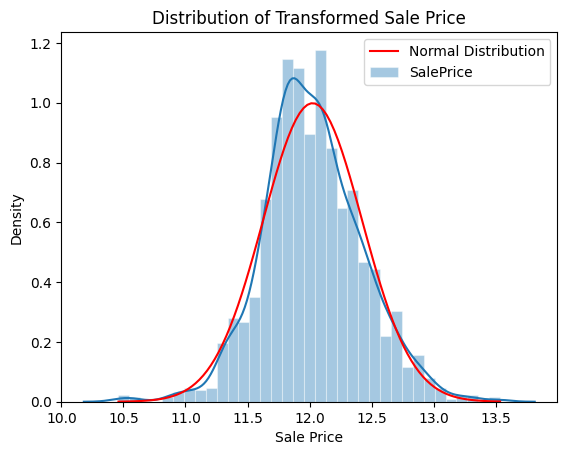

In [ ]:
# Logarithmic transformation of SalePrice
df_train['SalePrice'] = np.log(df_train['SalePrice'])

# Plot the distribution of the transformed SalePrice
sns.histplot(df_train['SalePrice'], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4), label='SalePrice')

mu, sigma = df_train['SalePrice'].mean(), df_train['SalePrice'].std()
x = np.linspace(df_train['SalePrice'].min(), df_train['SalePrice'].max(), 100)
y = norm.pdf(x, mu, sigma)

plt.plot(x, y, 'r-', label='Normal Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Density')
plt.title('Distribution of Transformed Sale Price')
plt.legend()
plt.show()

Now, the transformed Sale Price distribution is approximately Normal.

Next, we move onto handling missing values and label encoding for categorical features.

In [ ]:
# Handle missing values in the categorical and numerical features for both training and test data
for df in [df_train, df_test]:
  categorical_features = df.select_dtypes(include=['object']).columns
  numerical_features = df.select_dtypes(exclude=['object']).columns

  df[categorical_features] = df[categorical_features].fillna("missing")
  df[numerical_features] = df[numerical_features].fillna(df[numerical_features].mean())

  encoder = LabelEncoder()
  for column in categorical_features:
    df[column] = encoder.fit_transform(df[column])

In [ ]:
# Check that there are no missing values
null_counts_train = df_train.isna().sum().sort_values(ascending=False)
null_counts_train = null_counts_train[null_counts_train > 0]
print(null_counts_train)

null_counts_test = df_test.isna().sum().sort_values(ascending=False)
null_counts_test = null_counts_test[null_counts_test > 0]
print(null_counts_test)

Series([], dtype: int64)
Series([], dtype: int64)


In [ ]:
# Check that the categorical features have been transformed in training data
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,12.247694
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,12.109011
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,12.317167
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,11.849398
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,12.429216


In [ ]:
# Check that the categorical features have been transformed in test data
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,2,80.0,11622,1,2,3,3,0,...,120,0,2,2,3,0,6,2010,8,4
1,1462,20,3,81.0,14267,1,2,0,3,0,...,0,0,2,4,0,12500,6,2010,8,4
2,1463,60,3,74.0,13830,1,2,0,3,0,...,0,0,2,2,3,0,3,2010,8,4
3,1464,60,3,78.0,9978,1,2,0,3,0,...,0,0,2,4,3,0,6,2010,8,4
4,1465,120,3,43.0,5005,1,2,0,1,0,...,144,0,2,4,3,0,1,2010,8,4


# Training LightGBM and XGBoost

I will be using LGBMRegressor and XGBRegressor as my models.

In [ ]:
# Set X, y for training and test data
X_train = df_train.drop(['SalePrice'], axis=1)
y_train = df_train["SalePrice"]

X_test = df_test # will be used to print prediction

In [ ]:
# Split the training data into training and validation sets
random_state = 123
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=random_state)

In [ ]:
# Define function for cross-validation with cv=5
def mean_cross_val(model, X, y):
    score = cross_val_score(model, X, y, cv=5)
    mean = score.mean()
    return mean

In [ ]:
# Train the LightGBM model
LGBMR = LGBMRegressor(random_state=random_state)
LGBMR.fit(X_train, y_train)

y_pred_lgbm = LGBMR.predict(X_val)
rmse_lgbm = np.sqrt(mean_squared_error(y_val, y_pred_lgbm))
score_lgbm = LGBMR.score(X_val, y_val)
cv_lgbm = mean_cross_val(LGBMR, X_train, y_train)

# Train the XGBoost model
XGBR = XGBRegressor(seed=random_state)
XGBR.fit(X_train, y_train)

y_pred_xgb = XGBR.predict(X_val)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
score_xgb = XGBR.score(X_val, y_val)
cv_xgb = mean_cross_val(XGBR, X_train, y_train)

# Evaluation

In [ ]:
# Create a table to compare the models performances
table = pd.DataFrame({
    "Model": ["LightGBM", "XGBoost"],
    "CV=5": [cv_lgbm, cv_xgb],
    "R\u00b2": [score_lgbm, score_xgb],
    "MSE": [rmse_lgbm, rmse_xgb]
})
styled_table = table.style.set_table_styles(
    [{"selector": "th", "props": [("text-align", "center")]}]
)
styled_table

,Model,CV=5,R²,MSE
0,LightGBM,0.875553,0.886362,0.128301
1,XGBoost,0.859850,0.882298,0.130575


# Model Predictions

In [ ]:
# Preview the LGBMRegressor predicted values for the test data using the trained models
lgbm_pred = LGBMR.predict(X_test)
lgbm_pred = np.exp(lgbm_pred).round().astype(int)

lgbm_prediction = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': lgbm_pred})
print(f"LGBMRegressor Prediction:\n")
lgbm_prediction.head()

LGBMRegressor Prediction:



,Id,SalePrice
0,1461,120985
1,1462,155154
2,1463,182524
3,1464,180852
4,1465,177791


In [ ]:
# Preview the XGBRegressor predicted values for the test data using the trained models
xgb_pred = XGBR.predict(X_test)
xgb_pred = np.exp(xgb_pred).round().astype(int)

xgb_prediction = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': xgb_pred})
print(f"XGBRegressor Prediction:\n")
xgb_prediction.head()

XGBRegressor Prediction:



,Id,SalePrice
0,1461,125262
1,1462,159586
2,1463,186567
3,1464,173513
4,1465,190097


# Model Explainability with SHAP

**<font color='red'>NOTE:</font> <font color='blue'>It is important to remember that during the preprocessing of the data, I had done a logarithmic transformation of the target variable "SalePrice", therefore the values you view on the the below plots will be mirrored as such.</font>**

Now, let's see if we can use SHAP to explain the trained models.

In [ ]:
# Get SHAP values and SHAP interaction values for the trained LightGBM and XGBoost models
explainer_LGBM = shap.TreeExplainer(LGBMR)
shap_LGBM = explainer_LGBM(X_train)
shap_values_LGBM = explainer_LGBM.shap_values(X_train)
shap_interaction_values_LGBM = explainer_LGBM.shap_interaction_values(X_train)

explainer_XGB = shap.TreeExplainer(XGBR)
shap_XGB = explainer_XGB(X_train)
shap_values_XGB = explainer_XGB.shap_values(X_train)
shap_interaction_values_XGB = explainer_XGB.shap_interaction_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


## Global Interpretability

### Bar Plots

Below you will find the 2 different types of bar plots that could be printed in SHAP. There are four plots in total (2 for each model). The below bar plots function as feature importance plots for the LightGBM and XGBoost models. On the left-hand side, you will find the features sorted from top to bottom by impact level where the most influential feature is located at the top. The ranking is determined by their (the features) mean absolute SHAP values - the average magnitude of each feature's impact on the specific model's predicted house "SalePrice" across all instances. In the case of both models, this most impactful feature is "OverallQual", which is unsurprising as I resasonably expect that the overall quality of a house could have a significant impact on the sales price of the house in question.

Both LightGBM and XGBoost models have the same top 3 influential features: "OverallQual", "GrLivArea", and "TotalBsmtSF".

LGBMRegressor:


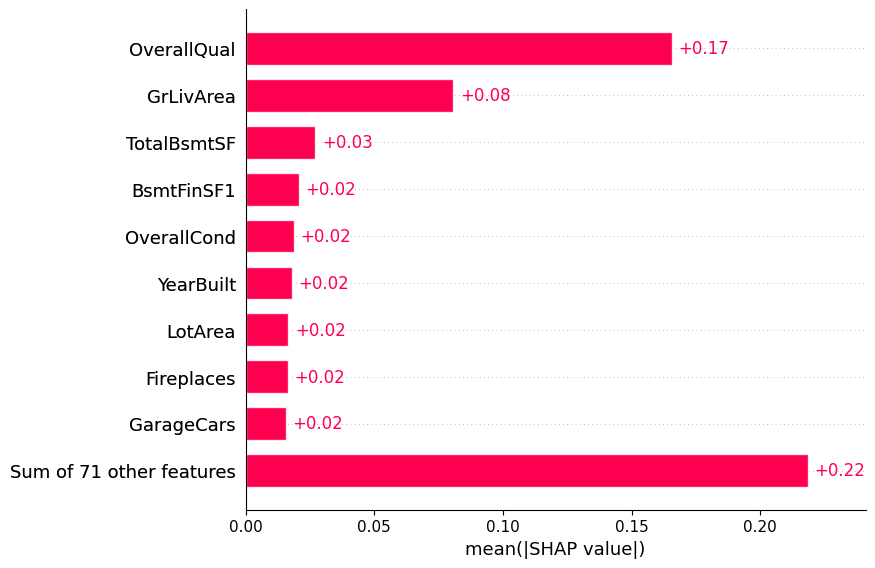


XGBRegressor:


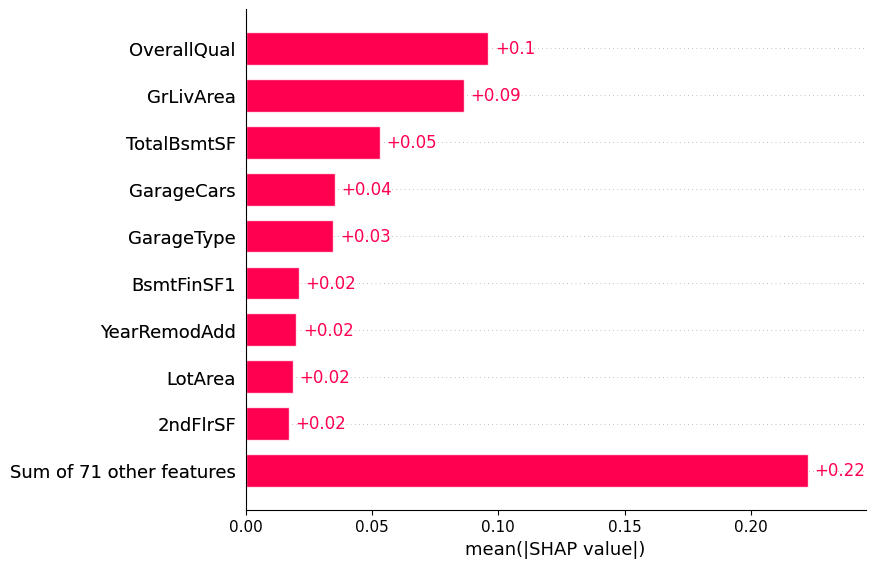

In [ ]:
# Plot
print(f"LGBMRegressor:")
shap.plots.bar(shap_LGBM, max_display=10)
print()
print(f"XGBRegressor:")
shap.plots.bar(shap_XGB, max_display=10)

LGBMRegressor:


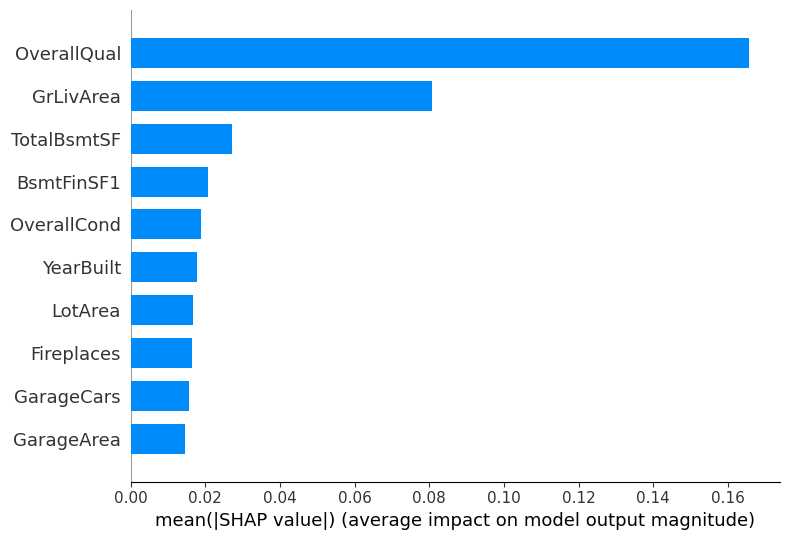


XGBRegressor:


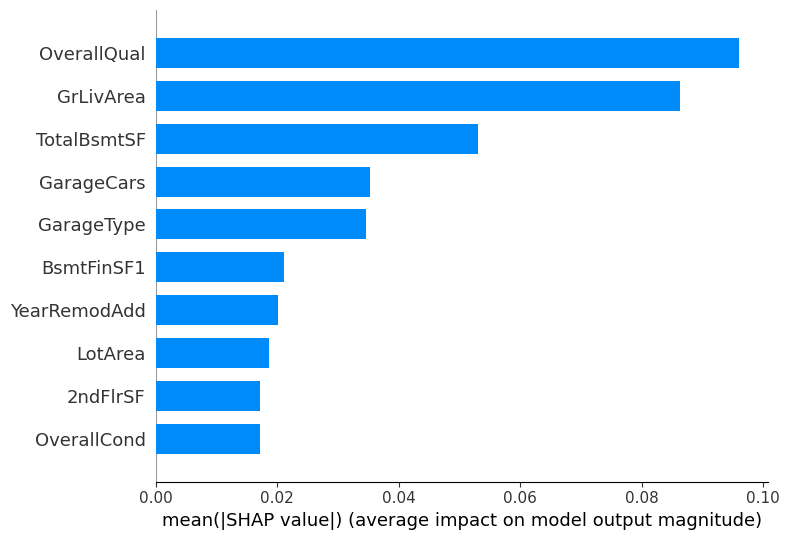

In [ ]:
print(f"LGBMRegressor:")
shap.summary_plot(shap_LGBM, plot_type='bar', max_display=10)
print()
print(f"XGBRegressor:")
shap.summary_plot(shap_XGB, plot_type='bar', max_display=10)

### Beeswarm Plots

Similar to the bar plot is a below beeswarm plot. Again, you will find feature importance ordered by most impactful feature down to least influential by SHAP value. However, beeswarm plots are able to illustrate more information of the SHAP values as they not only reveal the relative feature importance, but also the relationships with the specified model's prediction. Each point is a SHAP value that is distributed horizontally according to their respective SHAP values and stacked vertically showing density of the SHAP values. Each of the points are assigned a color corresponding to the raw values of the features where red indicates a high feature value and blue a low feature value. With the examination of the color distribution, insights can be made of each feature's directionality impact - the general relationship between the feature's raw values and its SHAP values.

In the case of "OverallQual", the feature with the highest impact for both models, a higher overall quality value leads to positive SHAP values indicating that a houses with high overall quality have higher sales prices predicted. Interestingly, for the XGBoost model, the feature "GarageType" has the reverse situation - where a lower "GarageType" value leads to higher house sales price prediction.

LGBMRegressor:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


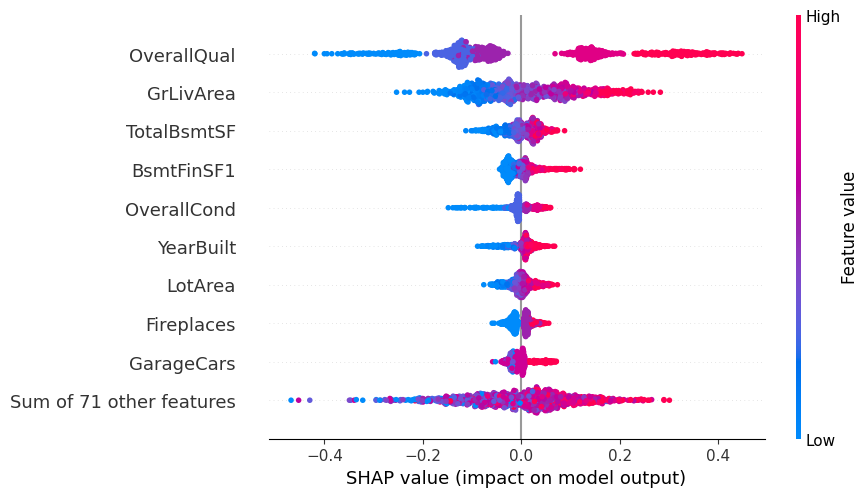


XGBRegressor:


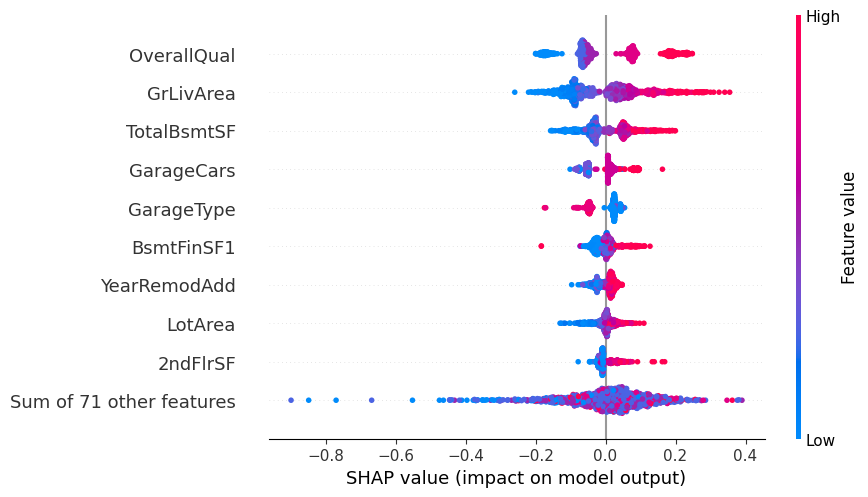

In [ ]:
print(f"LGBMRegressor:")
shap.plots.beeswarm(shap_LGBM, max_display=10)
print()
print(f"XGBRegressor:")
shap.plots.beeswarm(shap_XGB, max_display=10)

LGBMRegressor:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


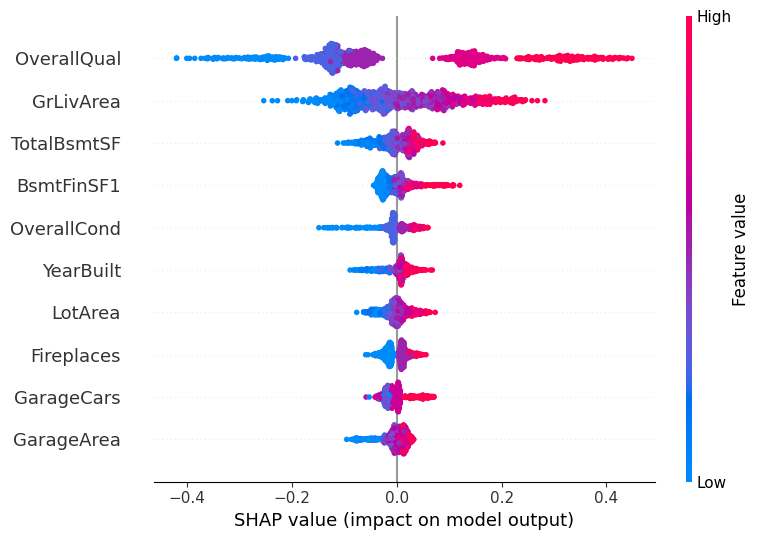


XGBRegressor:


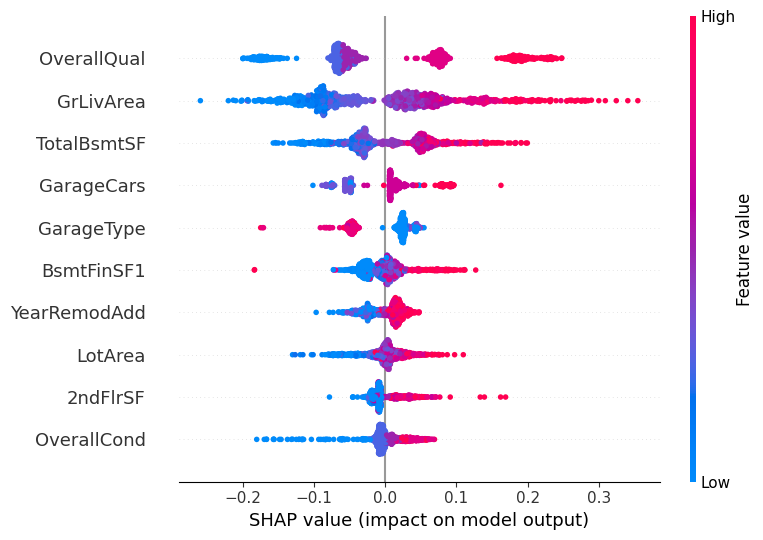

In [ ]:
print(f"LGBMRegressor:")
shap.summary_plot(shap_LGBM, max_display=10)
print()
print(f"XGBRegressor:")
shap.summary_plot(shap_XGB, max_display=10)

## Local Interpretability

### Waterfall Plots

Waterfall plots are great visualizations in that they are able to provide a more detailed breakdown of each feature's contribution towards the prediction of the house "SalePrice". The waterfall structure places emphasis on the additive nature of the positive and negative impacts built on the base value $E[f(X)]$ (the expected value of the house sales price model output) for yielding the specified model's prediction $f(X)$. In other words, each feature shows how the positive (red) or negative (blue) contribution moves the values from the expected model output over the dataset to the model prediction output.

Interestingly, for this instance, the top contributor for both models is different. For LightGBM, it is "OverallQual" pushing the prediction of the sales price to be low, could make sense as the year is stated to be 1996 and the overall quality is 5. However, for XGBoost, the top contributor is "GrLivArea" with "OverallQual" being the second.


LGBMRegressor:


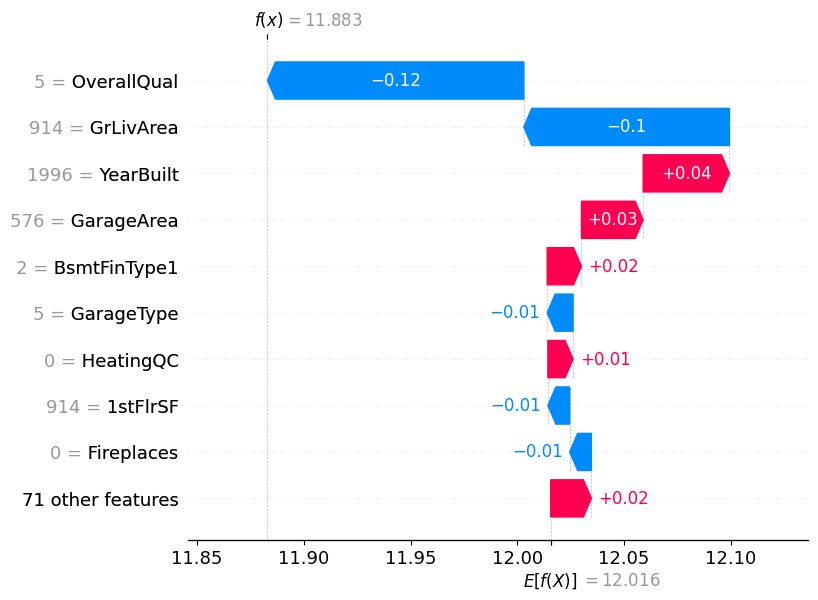


XGBRegressor:


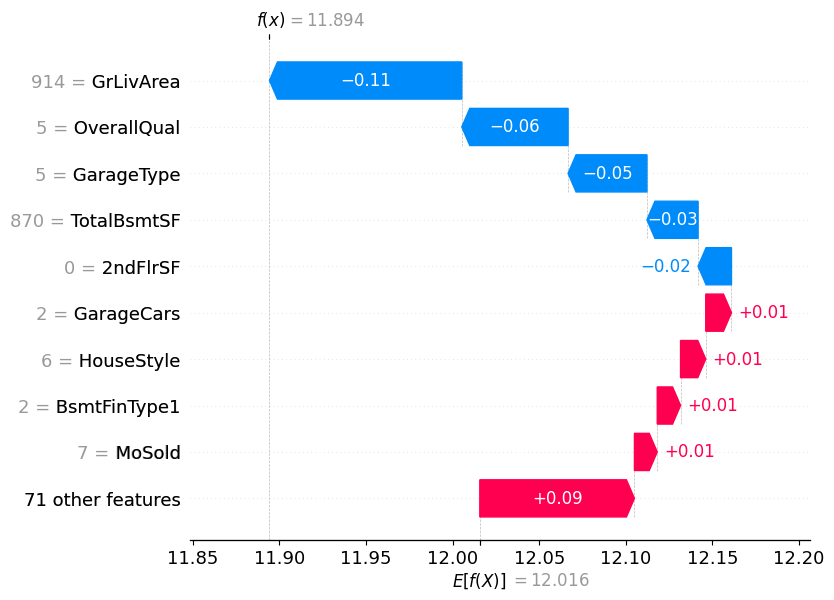

In [ ]:
print(f"LGBMRegressor:")
shap.plots.waterfall(shap_LGBM[0], max_display=10)
print()
print(f"XGBRegressor:")
shap.plots.waterfall(shap_XGB[0], max_display=10)

### Force Plots

Similar to the waterfall plots, the force plots also display just how much each feature "pushes" the model towards a higher or lower "SalePrice", but in a condensed format. As stated in the previous section for the waterfall plots, LightGBM's top contributing feature "OverallQual" is the feature that pushes to a lower predicted house sales price and for XGBoost, the feature is "GrLivArea".

In [ ]:
print(f"LGBMRegressor:")
shap.initjs()
shap.plots.force(shap_LGBM[0])

LGBMRegressor:


In [ ]:
print(f"XGBRegressor:")
shap.initjs()
shap.plots.force(shap_XGB[0])

XGBRegressor:


## SHAP Interaction Values

Below I plotted the interaction effects between features SHAP values. I chose the top 5 features that contributed the most to the specified model's prediction. In the first plot for LightGBM, for example, you can see the interaction effects of "OverallQual" and "GarageCars" features.

LGBMRegressor:


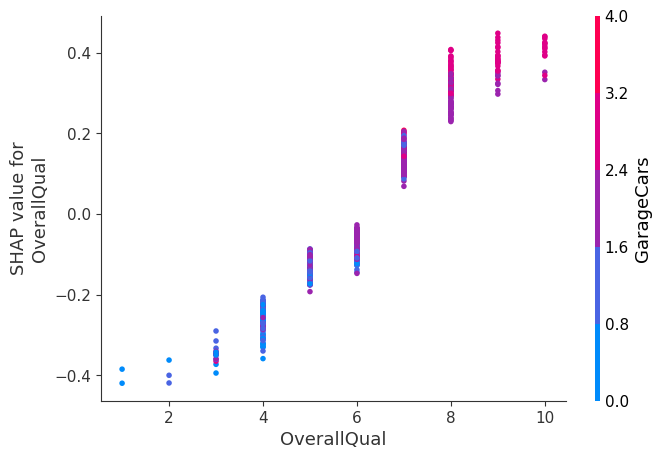

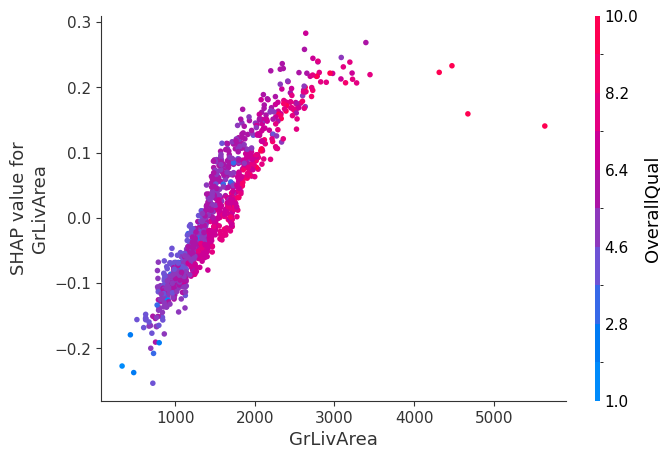

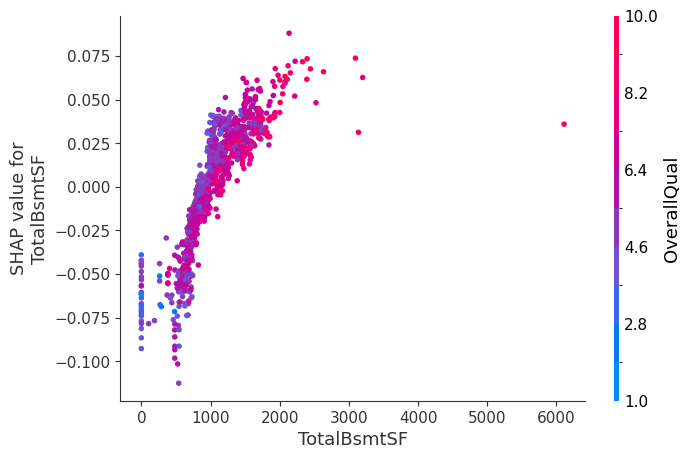

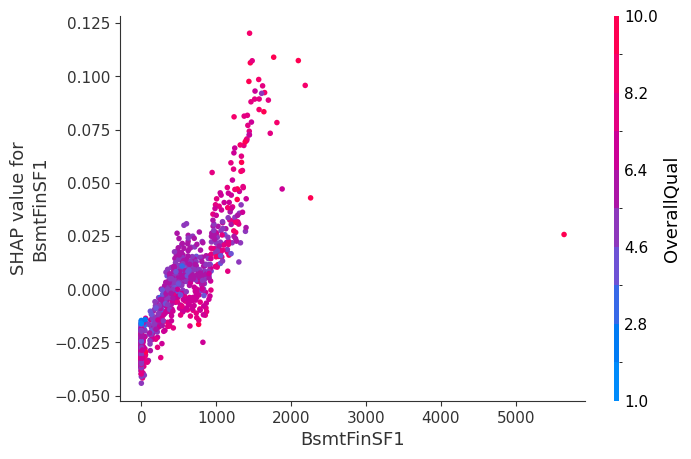

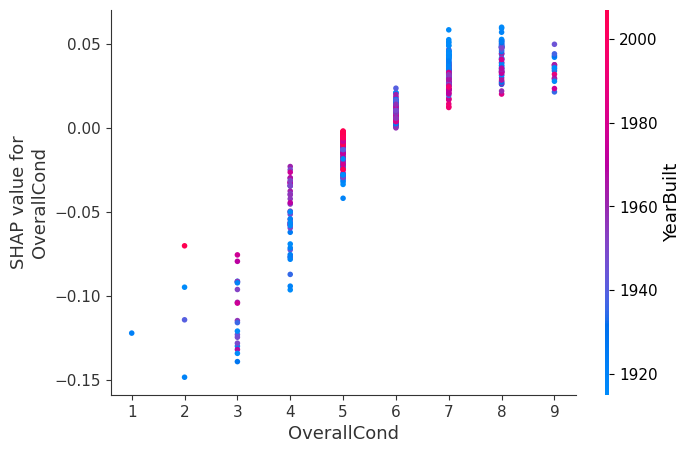

In [ ]:
# Top 5
print("LGBMRegressor:")
shap.dependence_plot("OverallQual", shap_values_LGBM, X_train)
print()
shap.dependence_plot("GrLivArea", shap_values_LGBM, X_train)
print()
shap.dependence_plot("TotalBsmtSF", shap_values_LGBM, X_train)
print()
shap.dependence_plot("BsmtFinSF1", shap_values_LGBM, X_train)
print()
shap.dependence_plot("OverallCond", shap_values_LGBM, X_train)

XGBRegressor


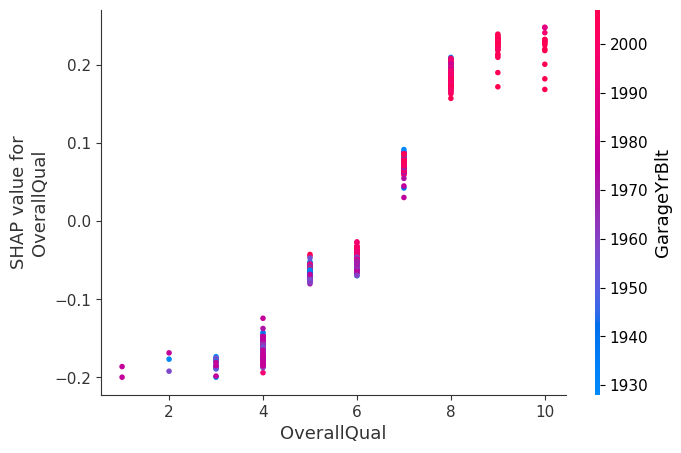

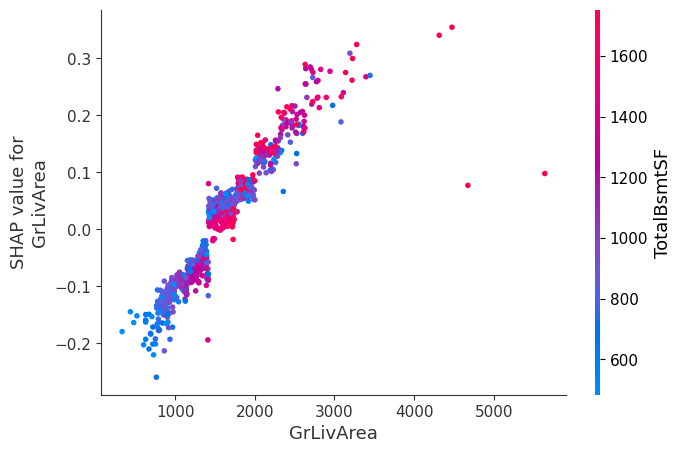

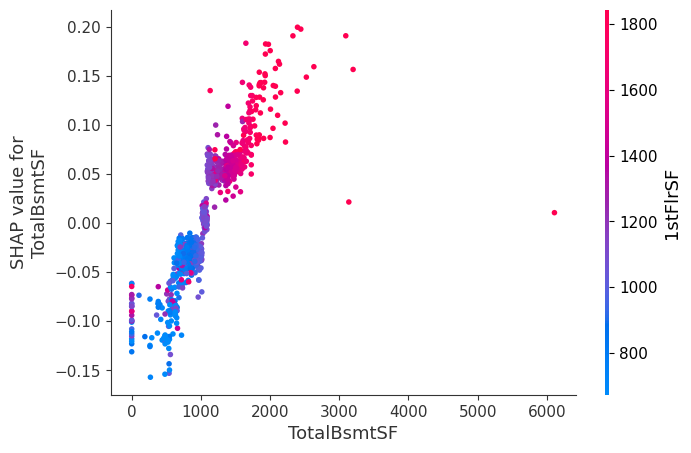

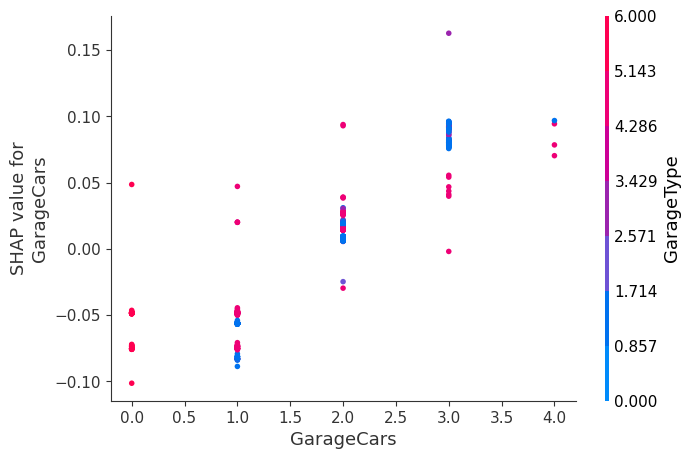

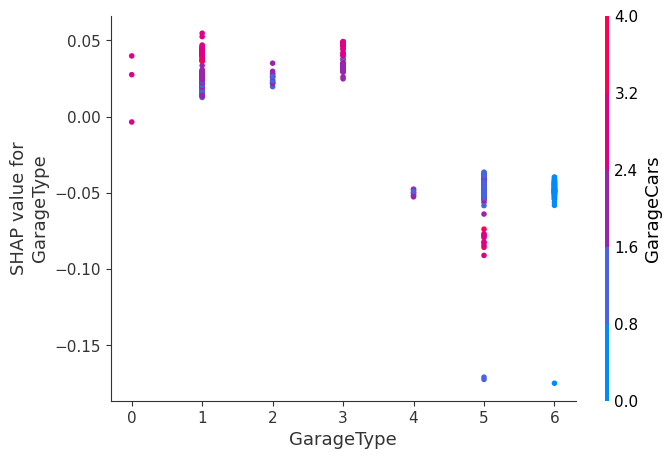

In [ ]:
print("XGBRegressor")
shap.dependence_plot("OverallQual", shap_values_XGB, X_train)
print()
shap.dependence_plot("GrLivArea", shap_values_XGB, X_train)
print()
shap.dependence_plot("TotalBsmtSF", shap_values_XGB, X_train)
print()
shap.dependence_plot("GarageCars", shap_values_XGB, X_train)
print()
shap.dependence_plot("GarageType", shap_values_XGB, X_train)

Below are plots for each model that appear almost similarly in the form of a Correlation Matrix. This is more of an overview of feature importances along with their interactions with other features.

LGBMRegressor:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


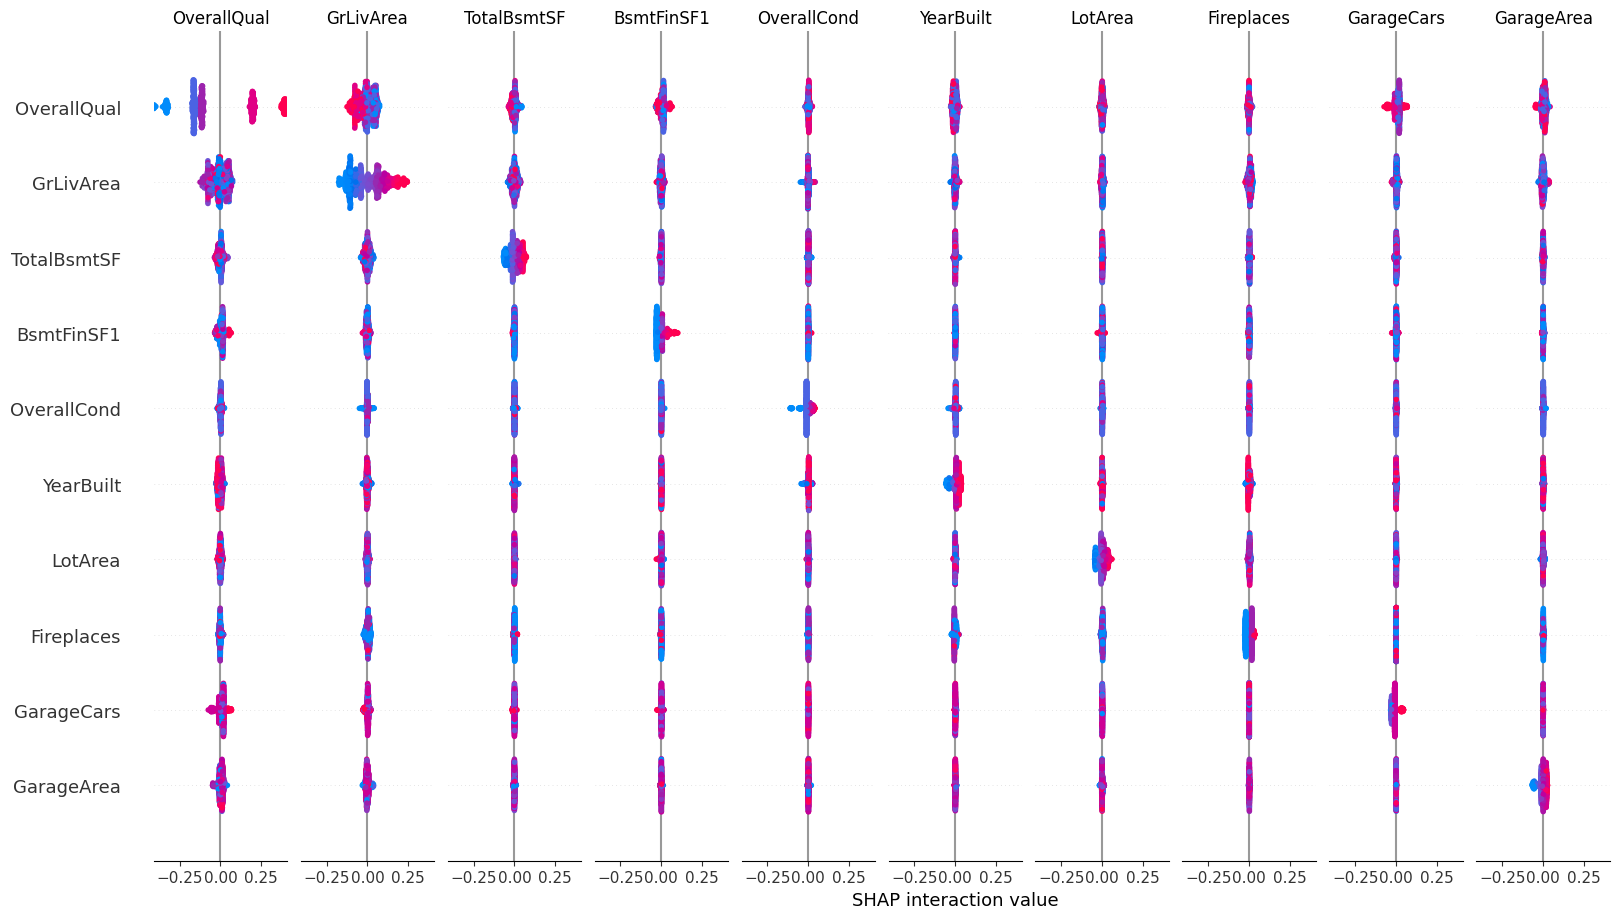


XGBRegressor


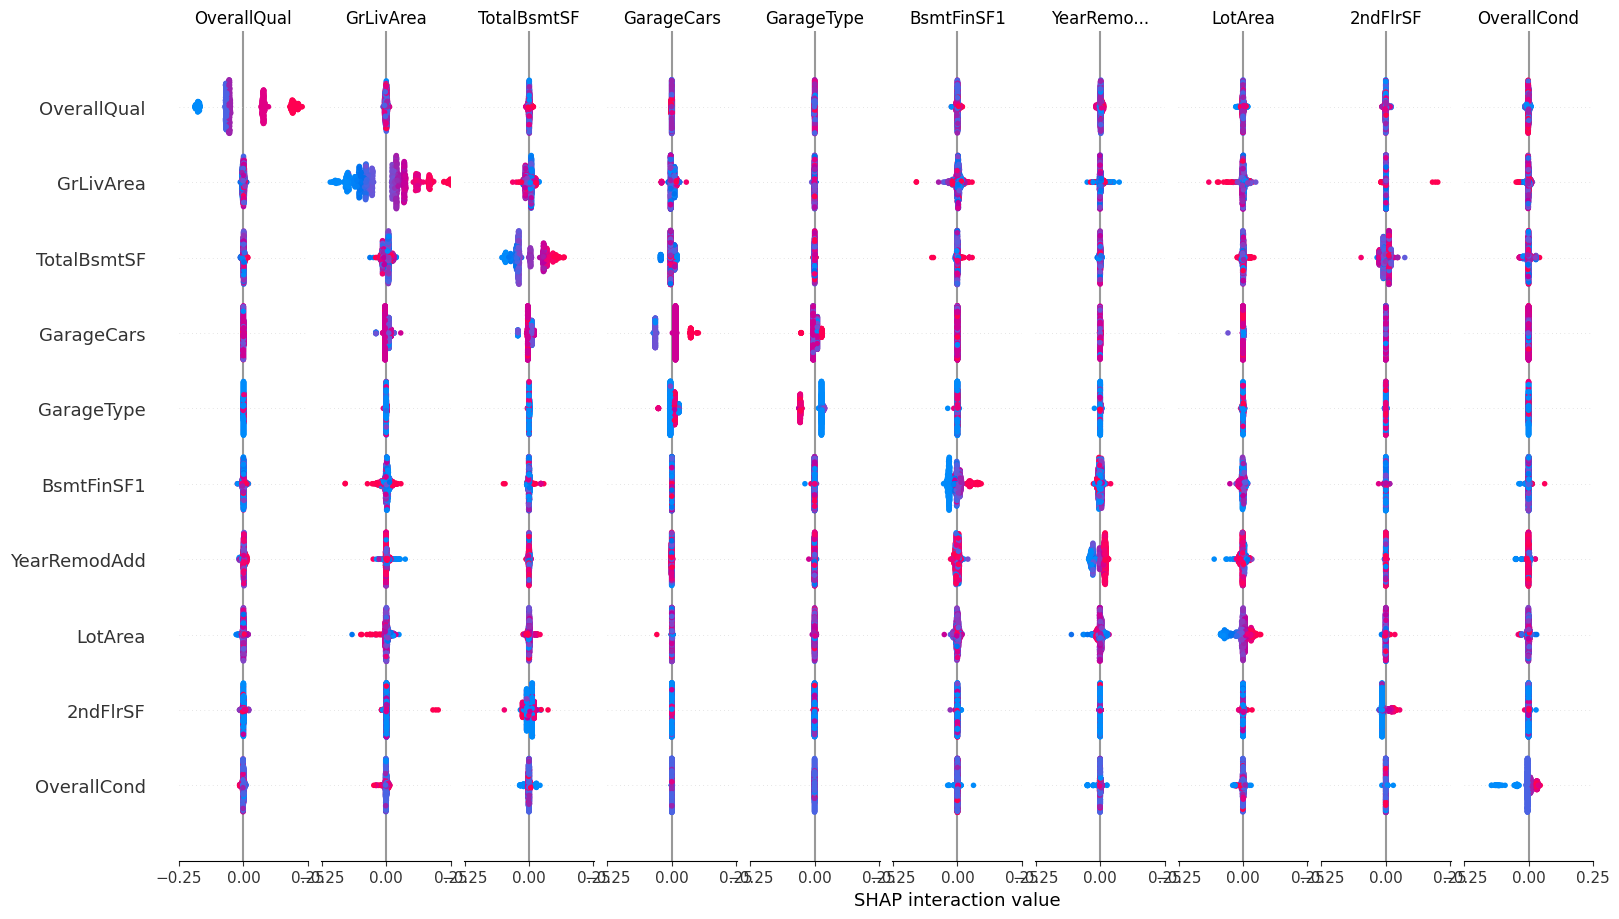

In [ ]:
print("LGBMRegressor:")
shap.summary_plot(shap_interaction_values_LGBM, X_train, max_display=10)
print()
print("XGBRegressor")
shap.summary_plot(shap_interaction_values_XGB, X_train, max_display=10)